# Setup

In [1]:
# Enable auto-reloading of imports when they have been modified
from IPython import get_ipython
ipython = get_ipython(); assert ipython is not None
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

import os
import json
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import plotly.express as px
import plotly.graph_objects as go
from tqdm.notebook import tqdm

# Disable gradient computation - this notebook will only perform forward passes
torch.set_grad_enabled(False)

from pathlib import Path
import sys
import os

# Add the base (root) directory to the path so we can import the util modules
def get_base_folder(project_root = "Count_PIPNet"):
	# Find the project root dynamically
	current_dir = os.getcwd()
	while True:
		if os.path.basename(current_dir) == project_root:  # Adjust to match your project root folder name
			break
		parent = os.path.dirname(current_dir)
		if parent == current_dir:  # Stop if we reach the system root (failsafe)
			raise RuntimeError(f"Project root {project_root} not found. Check your folder structure.")
		current_dir = parent

	return Path(current_dir)

base_path = get_base_folder()
print(f"Base path: {base_path}")
sys.path.append(str(base_path))

Base path: /mnt/ssd-1/mechinterp/taras/Count_PIPNet


In [2]:
from util.vis_pipnet import visualize_topk
from pipnet.count_pipnet import get_count_network
from util.checkpoint_manager import CheckpointManager
from pipnet.test import evaluate_model_lightweight
from util.data import get_dataloaders
from util.args import get_args
from util.vis_pipnet import visualize_topk

In [3]:
# Device setup
GPU_TO_USE = 2

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = f"cuda:{GPU_TO_USE}" if torch.cuda.is_available() else "cpu"

print(f'>>> Using {device} device <<<')

>>> Using cuda:2 device <<<


# Loading utilities

In [19]:
# Function to load a model from a checkpoint
def load_model(run_dir, checkpoint_name='net_trained_best', base_path=base_path, gpu_id=GPU_TO_USE):
    """
    Load a model from a checkpoint directory for evaluation purposes.

    Args:
        run_dir: Directory containing the run results
        checkpoint_name: Name of checkpoint to load (default: 'net_trained_best')
        base_path: Base path for dataset directories
        gpu_id: GPU ID to use
        
    Returns:
        Tuple of (net, trainloader, testloader, classes, args, is_count_pipnet)
    """
    # Step 1: Load the configuration used for this run
    metadata_dir = os.path.join(run_dir, 'metadata')
    args_path = os.path.join(metadata_dir, 'args.pickle')

    import pickle
    with open(args_path, 'rb') as f:
        args = pickle.load(f)
    print(f"Loaded configuration from {args_path}")

    # Explicitly set GPU ID to ensure device consistency
    if torch.cuda.is_available():
        args.gpu_ids = str(gpu_id)
        device = torch.device(f'cuda:{gpu_id}')
        torch.cuda.set_device(device)
    else:
        device = torch.device('cpu')

    print(f"Using device: {device}")

    # Step 2: Create dataloaders
    args.log_dir = run_dir  # Use the run directory as log_dir
    trainloader, trainloader_pretraining, trainloader_normal, \
    trainloader_normal_augment, projectloader, valid_loader, testloader, classes = get_dataloaders(args, device, base_path,
                                                                                                    test_set_projection_full=True)
    # Step 3: Create a model with the same architecture
    if hasattr(args, 'model') and args.model == 'count_pipnet':
        is_count_pipnet = True
        net, num_prototypes = get_count_network(
            num_classes=len(classes), 
            args=args,
            max_count=getattr(args, 'max_count', 3),
            use_ste=getattr(args, 'use_ste', False))
    else:
        is_count_pipnet = False
        net, num_prototypes = get_pipnet(len(classes), args)

    # Step 4: Move model to device
    net = net.to(device)

    # Step 5: Forward one batch through the backbone to get the latent output size
    with torch.no_grad():
        # Use a small batch to determine output shape
        xs1, _, _ = next(iter(trainloader))
        xs1 = xs1.to(device)

        # Single-forward pass without DataParallel
        features = net._net(xs1)
        proto_features = net._add_on(features)

        wshape = proto_features.shape[-1]
        args.wshape = wshape  # needed for calculating image patch size
        print(f"Output shape: {proto_features.shape}, setting wshape={wshape}")
            
    # Step 6: Now wrap with DataParallel
    device_ids = [gpu_id]
    print(f"Using device_ids: {device_ids}")
    net = nn.DataParallel(net, device_ids=device_ids)

    # Step 7: Direct checkpoint loading
    checkpoint_path = os.path.join(run_dir, 'checkpoints', checkpoint_name)
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found at {checkpoint_path}, trying alternative paths...")
        # Try with full path as fallback
        if os.path.exists(checkpoint_name):
            checkpoint_path = checkpoint_name
        else:
            # Try other common checkpoint names
            alternatives = [
                os.path.join(run_dir, 'checkpoints', 'net_trained_last'),
                os.path.join(run_dir, 'checkpoints', 'net_trained'),
                checkpoint_name # in case the direct path was passed
            ]
            for alt_path in alternatives:
                if os.path.exists(alt_path):
                    checkpoint_path = alt_path
                    print(f"Found alternative checkpoint at {checkpoint_path}")
                    break
            else:
                print("No checkpoint found")
                return None, None, None, None, None, None

    try:
        # Load just the model state dict
        checkpoint = torch.load(checkpoint_path, map_location=device)
        
        if 'model_state_dict' in checkpoint:
            net.load_state_dict(checkpoint['model_state_dict'], strict=True)
            print(f"Successfully loaded model state from {checkpoint_path}")
            
            # Display additional information if available
            if 'epoch' in checkpoint:
                print(f"Checkpoint from epoch {checkpoint['epoch']}")
            if 'accuracy' in checkpoint:
                print(f"Model accuracy: {checkpoint['accuracy']:.4f}")
            
            return net, testloader, classes, args, is_count_pipnet
        else:
            print(f"Checkpoint doesn't contain model_state_dict")
            return None, None, None, None, None, None
            
    except Exception as e:
        print(f"Error loading checkpoint: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None, None, None, None

# Evaluation utilities

In [5]:
import warnings
# Suppress SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
def evaluate_model(net, testloader, device, args=None):
    """
    Evaluate a model on the test set using a lightweight evaluation.
    
    Args:
        net: The model to evaluate
        testloader: DataLoader for the test set
        device: Device to run evaluation on
        args: Arguments object containing parameters (optional)
        
    Returns:
        Dictionary containing evaluation metrics
    """
    print("Evaluating model...")
    
    # Use the lightweight evaluation function
    eval_info = evaluate_model_lightweight(net, testloader, device)
    
    # If you still want to run the full eval_pipnet for additional metrics,
    # you can add a parameter to control this
    if args and getattr(args, 'run_full_evaluation', False):
        from pipnet.test import eval_pipnet
        enforce_weight_sparsity = getattr(args, 'enforce_weight_sparsity', True)
        full_eval_info = eval_pipnet(net, testloader, "evaluation", device, 
                                    log=None, enforce_weight_sparsity=enforce_weight_sparsity,
                                    args=args)
        # Add full evaluation metrics to the results
        eval_info.update(full_eval_info)
    
    return eval_info

In [7]:
# Function to load and parse the log_epoch_overview.csv file
def load_training_metrics(run_dir):
    """
    Load the training metrics from the log_epoch_overview.csv file.
    
    Args:
        run_dir: Directory containing the run results
        
    Returns:
        pandas DataFrame containing the metrics
    """
    log_path = os.path.join(run_dir, 'log_epoch_overview.csv')
    
    if not os.path.exists(log_path):
        print(f"Log file not found at {log_path}")
        return None
    
    try:
        # Load the CSV file
        df = pd.read_csv(log_path)
        
        # Convert 'n.a.' strings to NaN
        df = df.replace('n.a.', np.nan)
        
        # Convert to numeric types where possible
        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='ignore')
        
        # Determine which epochs were pretraining
        pretraining_mask = df['test_top1_acc'].isna()
        df['phase'] = 'training'
        df.loc[pretraining_mask, 'phase'] = 'pretraining'
        
        # Calculate the real epoch number (pretraining + training)
        df['real_epoch'] = df.index + 1
        
        # Calculate the training epoch number (just for the training phase)
        training_epochs = (~pretraining_mask).cumsum()
        df.loc[~pretraining_mask, 'training_epoch'] = training_epochs[~pretraining_mask]
        
        return df
    
    except Exception as e:
        print(f"Error loading log file: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

## Seed group evaluation

In [8]:
# Function to extract meaningful name and seed from run directory name
def extract_name_and_seed(run_name):
    """
    Extract the meaningful name and seed from a run directory name.
    
    Args:
        run_name: Name of the run directory
    
    Returns:
        Tuple of (meaningful_name, seed, full_name)
    """
    import re
    
    # Try to match patterns like "_s{seed}_" or "seed{seed}_" in the name
    seed_pattern = r'_s(\d+)_|seed(\d+)_'
    seed_match = re.search(seed_pattern, run_name)
    
    if seed_match:
        # Extract the seed value from the first successful group
        seed = seed_match.group(1) if seed_match.group(1) else seed_match.group(2)
        
        # Remove date pattern (assuming format like 'YYYYMMDD_HHMMSS_')
        date_pattern = r'^\d{8}_\d{6}_\d+_'
        name_without_date = re.sub(date_pattern, '', run_name)
        
        # Replace the seed part with a placeholder to get the meaningful name
        meaningful_name = re.sub(seed_pattern, '_SEED_', name_without_date)
        
        return meaningful_name, seed, run_name
    else:
        # If no seed found, use the full name
        return run_name, None, run_name

# Function to group run directories by meaningful name (ignoring seed and date)
def group_runs_by_config(run_dirs):
    """
    Group run directories by configuration (ignoring seed and date).
    
    Args:
        run_dirs: Dictionary mapping run names to run directories
    
    Returns:
        Dictionary mapping meaningful names to lists of (seed, run_dir) tuples
    """
    config_groups = {}
    
    for run_name, run_dir in run_dirs.items():
        meaningful_name, seed, full_name = extract_name_and_seed(run_name)
        
        if seed is not None:  # Only consider runs with identified seeds
            if meaningful_name not in config_groups:
                config_groups[meaningful_name] = []
            
            config_groups[meaningful_name].append((seed, run_dir, full_name))
    
    # Sort runs within each group by seed
    for group_name in config_groups:
        config_groups[group_name].sort(key=lambda x: int(x[0]))
    
    # Print summary of found groups
    print(f"Found {len(config_groups)} configuration groups:")
    for group_name, runs in config_groups.items():
        seed_list = [seed for seed, _, _ in runs]
        print(f"  - {group_name}: {len(runs)} runs with seeds {', '.join(seed_list)}")
    
    return config_groups

In [42]:
from util.histograms import class_idx_to_name
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate a group of runs with the same configuration but different seeds
def evaluate_run_group(config_name, seed_runs, output_dir, plot_confusion_matrix = True,
                       metrics_to_plot=None):
    """
    Evaluate a group of runs with the same configuration but different seeds.
    
    Args:
        config_name: Name of the configuration group
        seed_runs: List of (seed, run_dir, full_name) tuples for runs in this group
        output_dir: Directory to save evaluation results
    
    Returns:
        Dictionary containing evaluation results
    """
    print(f"\n{'='*60}")
    print(f"Evaluating configuration group: {config_name}")
    print(f"{'='*60}")

    # Hard-code the desired order for the confusion matrix
    desired_order = [
        "1 Circle", "2 Circles", "3 Circles",
        "1 Triangle", "2 Triangles", "3 Triangles",
        "1 Hexagon", "2 Hexagons", "3 Hexagons"
    ]
    
    group_output_dir = os.path.join(output_dir, config_name)
    os.makedirs(group_output_dir, exist_ok=True)
    
    results = {
        'config_name': config_name,
        'seeds': [],
        'test_accuracies': [],
        'seed_metrics': {}
    }
    
    # Initialize DataFrames for collecting metrics across seeds
    metrics_dfs = []
    
    # Evaluate each seed
    for seed, run_dir, full_name in seed_runs:
        print(f"\nEvaluating seed {seed} from {os.path.basename(run_dir)}")
        
        seed_output_dir = os.path.join(group_output_dir, f"seed_{seed}")
        os.makedirs(seed_output_dir, exist_ok=True)
        
        # Load the model for this seed
        net, testloader, classes, args, is_count_pipnet = load_model(
            run_dir, checkpoint_name='net_trained_best'
        )
        
        # Evaluate on test set
        eval_info = evaluate_model(net, testloader, device, args)

        # print(f'Finished evaluating {full_name}, results:\n', eval_info) 
        
        # Record results
        results['seeds'].append(seed)
        results['test_accuracies'].append(eval_info['accuracy'])
        results['seed_metrics'][seed] = eval_info
        
        # Save evaluation results for this seed
        eval_results_path = os.path.join(seed_output_dir, 'test_evaluation.json')
        with open(eval_results_path, 'w') as f:
            # Convert any non-serializable objects to strings
            serializable_info = {}
            for k, v in eval_info.items():
                if isinstance(v, (int, float, str, bool, list, dict)) or v is None:
                    serializable_info[k] = v
                else:
                    serializable_info[k] = str(v)
                    
            json.dump(serializable_info, f, indent=2)

        # Load training metrics for this seed
        df = load_training_metrics(run_dir)
        if df is not None:
            # Add seed information to the DataFrame
            df['seed'] = seed
            df['full_name'] = full_name
            metrics_dfs.append(df)

        # Plot confusion matrix if available
        if plot_confusion_matrix and 'confusion_matrix' in eval_info:
            # Create a directory for visualization
            vis_dir = os.path.join(seed_output_dir, 'visualizations')
            os.makedirs(vis_dir, exist_ok=True)
    
            # Get confusion matrix and class information
            cm = eval_info['confusion_matrix']
            num_classes = eval_info['num_classes']
            
            # Get class names for all indices
            class_names = [class_idx_to_name(i) for i in range(num_classes)]
            
            # Convert class names to indices
            reorder_idx = []
            for desired_name in desired_order:
                if desired_name in class_names:
                    idx = class_names.index(desired_name)
                    reorder_idx.append(idx)
            
            # If we have the wrong number of classes, fall back to original order
            if len(reorder_idx) != num_classes:
                print(f"Warning: Not all classes found in desired order. Using original order.")
                reorder_idx = list(range(num_classes))
            
            # Reorder confusion matrix
            cm_reordered = cm[reorder_idx, :][:, reorder_idx]
            class_names_reordered = [class_names[i] for i in reorder_idx]
            
            # Plot confusion matrix
            plt.figure(figsize=(12, 10))
            sns.heatmap(cm_reordered, annot=True, fmt='d', cmap='Blues',
                       xticklabels=class_names_reordered,
                       yticklabels=class_names_reordered)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Confusion Matrix {full_name}')
            
            # Rotate x labels for better readability
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            
            # Save the plot
            cm_path = os.path.join(vis_dir, 'confusion_matrix.png')
            plt.savefig(cm_path, bbox_inches='tight')
    
            display(plt.gcf())
            plt.close()
    
    # Calculate mean and standard deviation of test accuracies
    if results['test_accuracies']:
        results['mean_accuracy'] = np.mean(results['test_accuracies'])
        results['std_accuracy'] = np.std(results['test_accuracies'])
        
        print(f"\nTest accuracy across {len(results['seeds'])} seeds:")
        print(f"  Mean: {results['mean_accuracy']:.4f}")
        print(f"  Std: {results['std_accuracy']:.4f}")
        print(f"  Range: {min(results['test_accuracies']):.4f} - {max(results['test_accuracies']):.4f}")
        
        # Save summary of test accuracies
        summary_path = os.path.join(group_output_dir, 'test_accuracy_summary.json')
        with open(summary_path, 'w') as f:
            json.dump({
                'config_name': config_name,
                'seeds': results['seeds'],
                'test_accuracies': results['test_accuracies'],
                'mean_accuracy': results['mean_accuracy'],
                'std_accuracy': results['std_accuracy']
            }, f, indent=2)
    
    # Merge metrics DataFrames and create plots with error bars
    if metrics_dfs:
        combined_df = pd.concat(metrics_dfs, ignore_index=True)
        results['combined_metrics'] = combined_df
        
        # Plot metrics with error bars
        plot_group_metrics(combined_df, group_output_dir, config_name, metrics_to_plot=metrics_to_plot)
    
    return results

In [39]:
# Function to plot metrics for a group of runs with error bars
def plot_group_metrics(combined_df, output_dir, config_name, metrics_to_plot=None):
    """
    Plot metrics for a group of runs with the same configuration but different seeds,
    showing mean and standard deviation as error bars.
    
    Args:
        combined_df: DataFrame containing metrics for all seeds
        output_dir: Directory to save plots
        config_name: Name of the configuration group
    
    Returns:
        Dictionary of plotly figure objects
    """
    figures = {}

    if metrics_to_plot is None:
        # List of metrics to plot
        metrics_to_plot = [
            ('test_top1_acc', 'Test Accuracy', 'Accuracy'),
            ('local_size_for_true_class', 'Local Size for True Classes', 'Size'),
            ('local_size_all_classes', 'Local Size for All Classes', 'Size'),
            ('almost_nonzeros_pooled', 'Non-zero prototypes count', 'Count')
        ]
    
    # Only keep training phase data
    training_df = combined_df[combined_df['phase'] == 'training']
    
    # For each metric
    for metric, title, y_axis_title in metrics_to_plot:
        if metric in training_df.columns and not training_df[metric].isna().all():
            # Group by training epoch and calculate statistics
            metrics_by_epoch = training_df.groupby('training_epoch')[metric].agg(['mean', 'std']).reset_index()
            
            # Create figure with error bars
            fig = go.Figure()
            
            # Add mean line
            fig.add_trace(go.Scatter(
                x=metrics_by_epoch['training_epoch'],
                y=metrics_by_epoch['mean'],
                mode='lines+markers',
                name='Mean',
                line=dict(color='royalblue'),
                marker=dict(size=8)
            ))
            
            # Add error bands (mean ± std)
            fig.add_trace(go.Scatter(
                x=metrics_by_epoch['training_epoch'],
                y=metrics_by_epoch['mean'] + metrics_by_epoch['std'],
                mode='lines',
                name='Upper Bound',
                line=dict(width=0),
                showlegend=False
            ))
            
            fig.add_trace(go.Scatter(
                x=metrics_by_epoch['training_epoch'],
                y=metrics_by_epoch['mean'] - metrics_by_epoch['std'],
                mode='lines',
                name='Lower Bound',
                line=dict(width=0),
                fill='tonexty',
                fillcolor='rgba(65, 105, 225, 0.2)',
                showlegend=False
            ))
            
            # Update layout
            fig.update_layout(
                title=f"{title} (Mean ± Std across seeds) - {config_name}",
                xaxis_title="Epoch",
                yaxis_title=y_axis_title,
                legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
                xaxis=dict(showgrid=True),
                yaxis=dict(showgrid=True),
                hovermode="x unified"
            )
            
            # Save figure
            fig_path = os.path.join(output_dir, f"{metric}_with_error_bars.html")
            fig.write_html(fig_path)
            
            # Display the figure in the notebook
            from IPython.display import display
            display(fig)
            
            figures[metric] = fig
    
    # Also create a plot showing all individual seed trajectories
    for metric, title, y_axis_title in metrics_to_plot:
        if metric in training_df.columns and not training_df[metric].isna().all():
            # Create figure for individual seeds
            fig = px.line(
                training_df, 
                x='training_epoch', 
                y=metric, 
                color='seed',
                title=f"{title} (Individual Seeds) - {config_name}",
                labels={'training_epoch': 'Epoch', metric: y_axis_title}
            )
            
            # Update layout
            fig.update_layout(
                legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
                xaxis=dict(showgrid=True),
                yaxis=dict(showgrid=True)
            )
            
            # Save figure
            fig_path = os.path.join(output_dir, f"{metric}_individual_seeds.html")
            fig.write_html(fig_path)
            
            # Display the figure in the notebook
            from IPython.display import display
            display(fig)
            
            figures[f"{metric}_individual"] = fig
    
    return figures

# Loading the models

In [11]:
# Define the base directory for your experiments
multi_experiment_dir = base_path / 'runs/final' 
print(f"Experiment directory: {multi_experiment_dir}")

Experiment directory: /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final


In [12]:
# Create a directory for saving evaluation results
eval_results_dir = base_path / 'evaluations'
os.makedirs(eval_results_dir, exist_ok=True)
print(f"Evaluation results will be saved to {eval_results_dir}")

Evaluation results will be saved to /mnt/ssd-1/mechinterp/taras/Count_PIPNet/evaluations


In [13]:
summary_path = os.path.join(multi_experiment_dir, 'summary.json')

try:
	# Load the summary file to get all run directories
	with open(summary_path, 'r') as f:
		summary = json.load(f)

	print(f"Found {len(summary)} trained models")
except FileNotFoundError:
    summary = None
    print(f"Summary file NOT found at {summary_path}. Please ensure the training was completed and the summary file was generated.")

Summary file NOT found at /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/summary.json. Please ensure the training was completed and the summary file was generated.


In [14]:
# Option to use hard-coded run directories (specify just the base names)
hard_coded_run_dirs = [
]

if hard_coded_run_dirs:
    # Convert base names to full paths (assume they're in the 'runs/' folder)
    run_dirs = {}
    for run_name in hard_coded_run_dirs:
        full_path = base_path / 'runs' / run_name
        if os.path.isdir(full_path) and os.path.exists(os.path.join(full_path, 'metadata')):
            run_dirs[run_name] = str(full_path)
        else:
            print(f"Warning: Run directory '{run_name}' not found at {full_path}")
    print(f"Using {len(run_dirs)} manually specified run directories")
elif summary is None:
    run_dirs = {}
    for item in os.listdir(multi_experiment_dir):
        item_path = os.path.join(multi_experiment_dir, item)
        if os.path.isdir(item_path) and os.path.exists(os.path.join(item_path, 'metadata')):
            run_dirs[item] = item_path
    print(f"Found {len(run_dirs)} run directories")
else:
    # Use the runs from the summary file
    run_dirs = {os.path.basename(run['output_dir']): run['output_dir'] for run in summary}

Found 28 run directories


In [15]:
# Select only the runs containing a specific string
filter_str = 'stage3_p16'  # Change this to filter different configurations
run_dirs = {dir: value for dir, value in run_dirs.items() if filter_str in dir}
run_dirs  # Display the filtered directories for verification

{'20250409_063106_11_final_s42_stage3_p16_linear': '/mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_063106_11_final_s42_stage3_p16_linear',
 '20250409_031241_2_final_s1_stage3_p16_onehot_train': '/mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_031241_2_final_s1_stage3_p16_onehot_train',
 '20250409_041831_5_final_s1_stage3_p16_identity_train': '/mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_041831_5_final_s1_stage3_p16_identity_train',
 '20250409_024941_1_final_s1_stage3_p16_linear': '/mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_024941_1_final_s1_stage3_p16_linear',
 '20250409_075946_15_final_s42_stage3_p16_identity_train': '/mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_075946_15_final_s42_stage3_p16_identity_train',
 '20250409_052530_8_final_s21_stage3_p16_linear_full_train': '/mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_052530_8_final_s21_stage3_p16_linear_full_train',
 '20250409_035637_4_final_s1_s

# Main part (multiple seeds)

## Evaluation part

In [31]:
# Group runs by configuration (ignoring seed and date)
config_groups = group_runs_by_config(run_dirs)
# config_groups

Found 5 configuration groups:
  - final_SEED_stage3_p16_linear: 3 runs with seeds 1, 21, 42
  - final_SEED_stage3_p16_onehot_train: 3 runs with seeds 1, 21, 42
  - final_SEED_stage3_p16_identity_train: 3 runs with seeds 1, 21, 42
  - final_SEED_stage3_p16_linear_full_train: 3 runs with seeds 1, 21, 42
  - final_SEED_stage3_p16_linear_train: 3 runs with seeds 1, 21, 42


In [43]:
# List of metrics to plot
metrics_to_plot = [
    ('test_top1_acc', 'Test Accuracy', 'Accuracy'),
    # ('local_size_for_true_class', 'Local Size for True Classes', 'Size'),
    # ('local_size_all_classes', 'Local Size for All Classes', 'Size'),
    # ('almost_nonzeros_pooled', 'Non-zero prototypes count', 'Count')
]

Evaluating configuration groups:   0%|          | 0/5 [00:00<?, ?it/s]


Evaluating configuration group: final_SEED_stage3_p16_linear

Evaluating seed 1 from 20250409_024941_1_final_s1_stage3_p16_linear
Loaded configuration from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_024941_1_final_s1_stage3_p16_linear/metadata/args.pickle
Using device: cuda:2
Num classes (k) =  9 ['class_1', 'class_2', 'class_3', 'class_4', 'class_5'] etc.
Detected 192 output channels from last conv layer
Number of prototypes set from 192 to 16. Extra 1x1 conv layer added.
Output shape: torch.Size([64, 16, 24, 24]), setting wshape=24
Using device_ids: [2]
Successfully loaded model state from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_024941_1_final_s1_stage3_p16_linear/checkpoints/net_trained_best
Checkpoint from epoch 74
Model accuracy: 0.7990
Evaluating model...



Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 17.06it/s]


Evaluation completed. Accuracy: 0.7678

Evaluating seed 21 from 20250409_044022_6_final_s21_stage3_p16_linear
Loaded configuration from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_044022_6_final_s21_stage3_p16_linear/metadata/args.pickle
Using device: cuda:2
Num classes (k) =  9 ['class_1', 'class_2', 'class_3', 'class_4', 'class_5'] etc.
Detected 192 output channels from last conv layer
Number of prototypes set from 192 to 16. Extra 1x1 conv layer added.
Output shape: torch.Size([64, 16, 24, 24]), setting wshape=24
Using device_ids: [2]
Successfully loaded model state from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_044022_6_final_s21_stage3_p16_linear/checkpoints/net_trained_best
Checkpoint from epoch 68
Model accuracy: 0.7708
Evaluating model...



Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 16.48it/s]

Evaluation completed. Accuracy: 0.7178

Evaluating seed 42 from 20250409_063106_11_final_s42_stage3_p16_linear
Loaded configuration from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_063106_11_final_s42_stage3_p16_linear/metadata/args.pickle
Using device: cuda:2
Num classes (k) =  9 ['class_1', 'class_2', 'class_3', 'class_4', 'class_5'] etc.


Detected 192 output channels from last conv layer
Number of prototypes set from 192 to 16. Extra 1x1 conv layer added.
Output shape: torch.Size([64, 16, 24, 24]), setting wshape=24
Using device_ids: [2]
Successfully loaded model state from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_063106_11_final_s42_stage3_p16_linear/checkpoints/net_trained_best
Checkpoint from epoch 54
Model accuracy: 0.7104
Evaluating model...



Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 17.06it/s]

Evaluation completed. Accuracy: 0.6889

Test accuracy across 3 seeds:
  Mean: 0.7248
  Std: 0.0326
  Range: 0.6889 - 0.7678


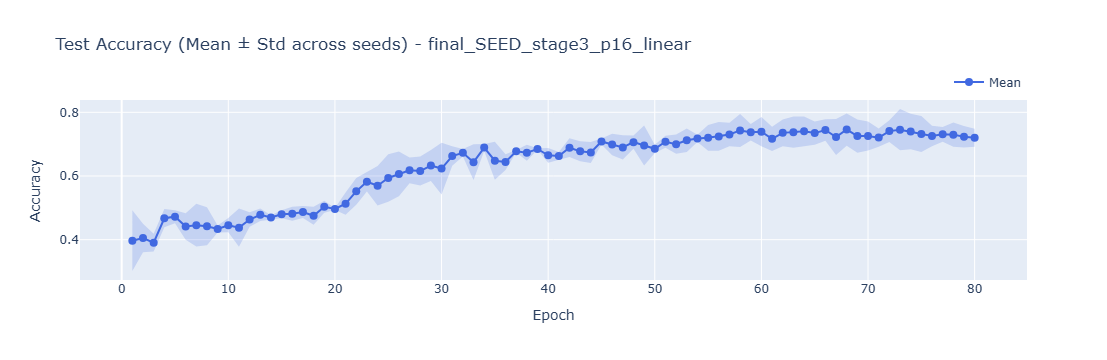

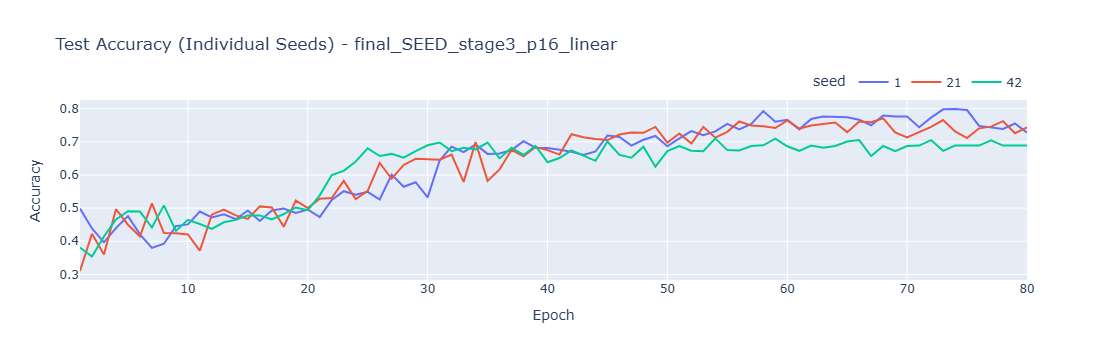


Evaluating configuration group: final_SEED_stage3_p16_onehot_train

Evaluating seed 1 from 20250409_031241_2_final_s1_stage3_p16_onehot_train
Loaded configuration from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_031241_2_final_s1_stage3_p16_onehot_train/metadata/args.pickle
Using device: cuda:2
Num classes (k) =  9 ['class_1', 'class_2', 'class_3', 'class_4', 'class_5'] etc.
Detected 192 output channels from last conv layer
Number of prototypes set from 192 to 16. Extra 1x1 conv layer added.
Output shape: torch.Size([64, 16, 24, 24]), setting wshape=24
Using device_ids: [2]
Successfully loaded model state from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_031241_2_final_s1_stage3_p16_onehot_train/checkpoints/net_trained_best
Checkpoint from epoch 46
Model accuracy: 0.8615
Evaluating model...



Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 17.79it/s]


Evaluation completed. Accuracy: 0.8222

Evaluating seed 21 from 20250409_050328_7_final_s21_stage3_p16_onehot_train
Loaded configuration from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_050328_7_final_s21_stage3_p16_onehot_train/metadata/args.pickle
Using device: cuda:2
Num classes (k) =  9 ['class_1', 'class_2', 'class_3', 'class_4', 'class_5'] etc.
Detected 192 output channels from last conv layer
Number of prototypes set from 192 to 16. Extra 1x1 conv layer added.
Output shape: torch.Size([64, 16, 24, 24]), setting wshape=24
Using device_ids: [2]
Successfully loaded model state from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_050328_7_final_s21_stage3_p16_onehot_train/checkpoints/net_trained_best
Checkpoint from epoch 71
Model accuracy: 0.8729
Evaluating model...



Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 16.61it/s]

Evaluation completed. Accuracy: 0.8367

Evaluating seed 42 from 20250409_065413_12_final_s42_stage3_p16_onehot_train
Loaded configuration from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_065413_12_final_s42_stage3_p16_onehot_train/metadata/args.pickle
Using device: cuda:2
Num classes (k) =  9 ['class_1', 'class_2', 'class_3', 'class_4', 'class_5'] etc.


Detected 192 output channels from last conv layer
Number of prototypes set from 192 to 16. Extra 1x1 conv layer added.
Output shape: torch.Size([64, 16, 24, 24]), setting wshape=24
Using device_ids: [2]
Successfully loaded model state from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_065413_12_final_s42_stage3_p16_onehot_train/checkpoints/net_trained_best
Checkpoint from epoch 72
Model accuracy: 0.8906
Evaluating model...



Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 16.15it/s]

Evaluation completed. Accuracy: 0.8822

Test accuracy across 3 seeds:
  Mean: 0.8470
  Std: 0.0256
  Range: 0.8222 - 0.8822


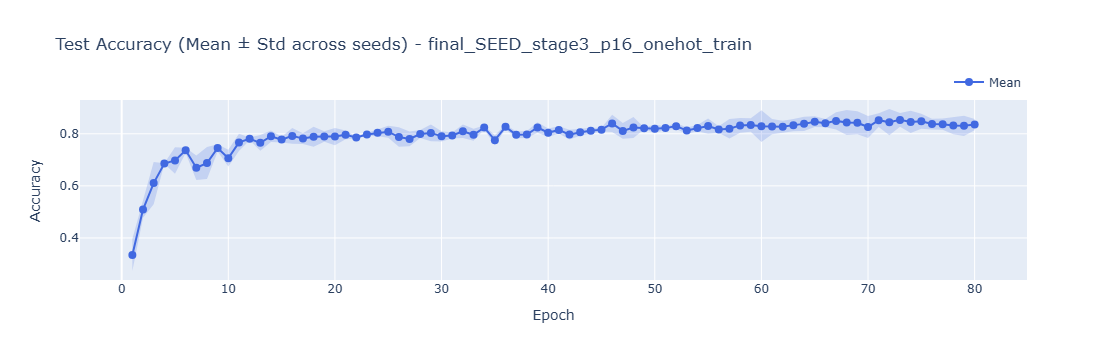

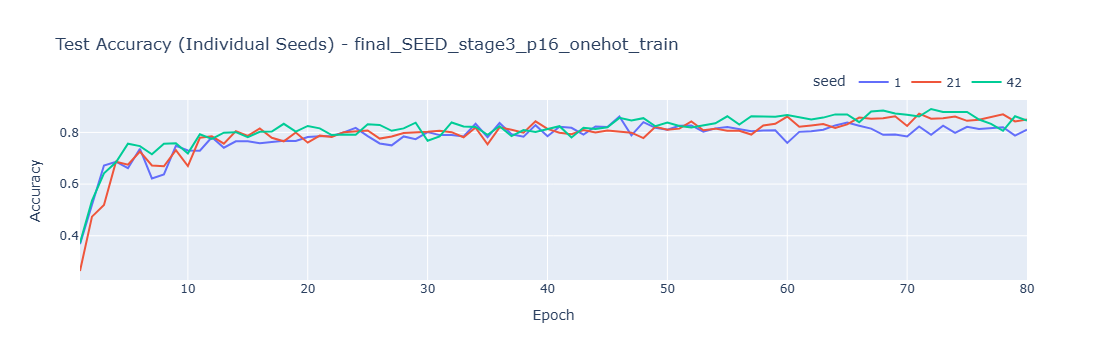


Evaluating configuration group: final_SEED_stage3_p16_identity_train

Evaluating seed 1 from 20250409_041831_5_final_s1_stage3_p16_identity_train
Loaded configuration from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_041831_5_final_s1_stage3_p16_identity_train/metadata/args.pickle
Using device: cuda:2
Num classes (k) =  9 ['class_1', 'class_2', 'class_3', 'class_4', 'class_5'] etc.
Detected 192 output channels from last conv layer
Number of prototypes set from 192 to 16. Extra 1x1 conv layer added.
Output shape: torch.Size([64, 16, 24, 24]), setting wshape=24
Using device_ids: [2]
Successfully loaded model state from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_041831_5_final_s1_stage3_p16_identity_train/checkpoints/net_trained_best
Checkpoint from epoch 73
Model accuracy: 0.9042
Evaluating model...



Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 17.12it/s]


Evaluation completed. Accuracy: 0.8889

Evaluating seed 21 from 20250409_060919_10_final_s21_stage3_p16_identity_train
Loaded configuration from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_060919_10_final_s21_stage3_p16_identity_train/metadata/args.pickle
Using device: cuda:2
Num classes (k) =  9 ['class_1', 'class_2', 'class_3', 'class_4', 'class_5'] etc.
Detected 192 output channels from last conv layer
Number of prototypes set from 192 to 16. Extra 1x1 conv layer added.
Output shape: torch.Size([64, 16, 24, 24]), setting wshape=24
Using device_ids: [2]
Successfully loaded model state from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_060919_10_final_s21_stage3_p16_identity_train/checkpoints/net_trained_best
Checkpoint from epoch 42
Model accuracy: 0.6969
Evaluating model...



Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 18.17it/s]


Evaluation completed. Accuracy: 0.6678

Evaluating seed 42 from 20250409_075946_15_final_s42_stage3_p16_identity_train
Loaded configuration from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_075946_15_final_s42_stage3_p16_identity_train/metadata/args.pickle
Using device: cuda:2
Num classes (k) =  9 ['class_1', 'class_2', 'class_3', 'class_4', 'class_5'] etc.
Detected 192 output channels from last conv layer
Number of prototypes set from 192 to 16. Extra 1x1 conv layer added.
Output shape: torch.Size([64, 16, 24, 24]), setting wshape=24
Using device_ids: [2]
Successfully loaded model state from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_075946_15_final_s42_stage3_p16_identity_train/checkpoints/net_trained_best
Checkpoint from epoch 57
Model accuracy: 0.9917
Evaluating model...



Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 16.83it/s]

Evaluation completed. Accuracy: 0.9889

Test accuracy across 3 seeds:
  Mean: 0.8485
  Std: 0.1342
  Range: 0.6678 - 0.9889


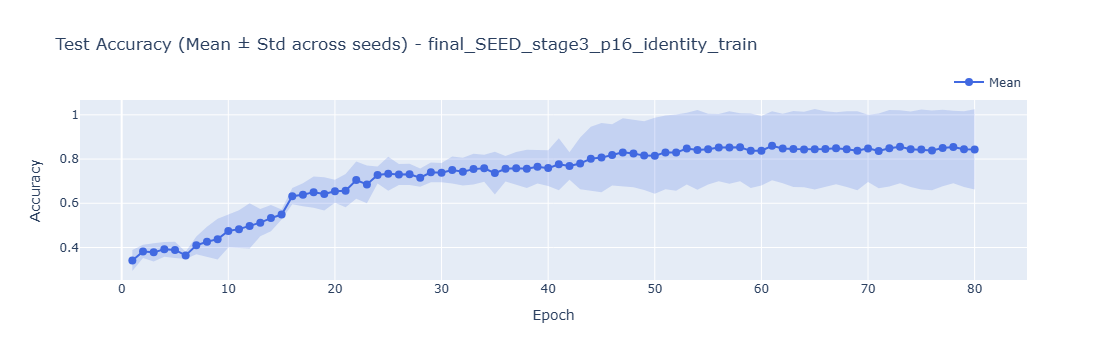

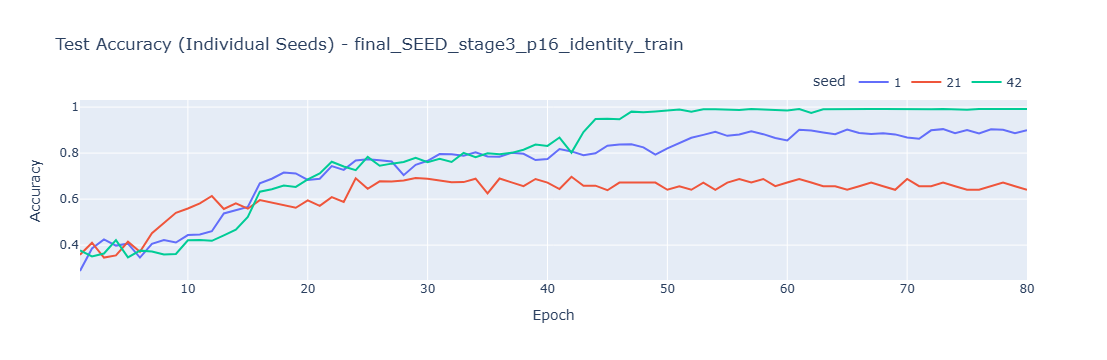


Evaluating configuration group: final_SEED_stage3_p16_linear_full_train

Evaluating seed 1 from 20250409_033445_3_final_s1_stage3_p16_linear_full_train
Loaded configuration from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_033445_3_final_s1_stage3_p16_linear_full_train/metadata/args.pickle
Using device: cuda:2
Num classes (k) =  9 ['class_1', 'class_2', 'class_3', 'class_4', 'class_5'] etc.
Detected 192 output channels from last conv layer
Number of prototypes set from 192 to 16. Extra 1x1 conv layer added.
Output shape: torch.Size([64, 16, 24, 24]), setting wshape=24
Using device_ids: [2]
Successfully loaded model state from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_033445_3_final_s1_stage3_p16_linear_full_train/checkpoints/net_trained_best
Checkpoint from epoch 75
Model accuracy: 0.9917
Evaluating model...



Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 16.25it/s]


Evaluation completed. Accuracy: 0.9822

Evaluating seed 21 from 20250409_052530_8_final_s21_stage3_p16_linear_full_train
Loaded configuration from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_052530_8_final_s21_stage3_p16_linear_full_train/metadata/args.pickle
Using device: cuda:2
Num classes (k) =  9 ['class_1', 'class_2', 'class_3', 'class_4', 'class_5'] etc.
Detected 192 output channels from last conv layer
Number of prototypes set from 192 to 16. Extra 1x1 conv layer added.
Output shape: torch.Size([64, 16, 24, 24]), setting wshape=24
Using device_ids: [2]
Successfully loaded model state from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_052530_8_final_s21_stage3_p16_linear_full_train/checkpoints/net_trained_best
Checkpoint from epoch 73
Model accuracy: 0.9906
Evaluating model...



Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 17.07it/s]


Evaluation completed. Accuracy: 0.9778

Evaluating seed 42 from 20250409_071614_13_final_s42_stage3_p16_linear_full_train
Loaded configuration from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_071614_13_final_s42_stage3_p16_linear_full_train/metadata/args.pickle
Using device: cuda:2
Num classes (k) =  9 ['class_1', 'class_2', 'class_3', 'class_4', 'class_5'] etc.
Detected 192 output channels from last conv layer
Number of prototypes set from 192 to 16. Extra 1x1 conv layer added.
Output shape: torch.Size([64, 16, 24, 24]), setting wshape=24
Using device_ids: [2]
Successfully loaded model state from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_071614_13_final_s42_stage3_p16_linear_full_train/checkpoints/net_trained_best
Checkpoint from epoch 69
Model accuracy: 0.9938
Evaluating model...



Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 18.15it/s]


Evaluation completed. Accuracy: 0.9956

Test accuracy across 3 seeds:
  Mean: 0.9852
  Std: 0.0076
  Range: 0.9778 - 0.9956


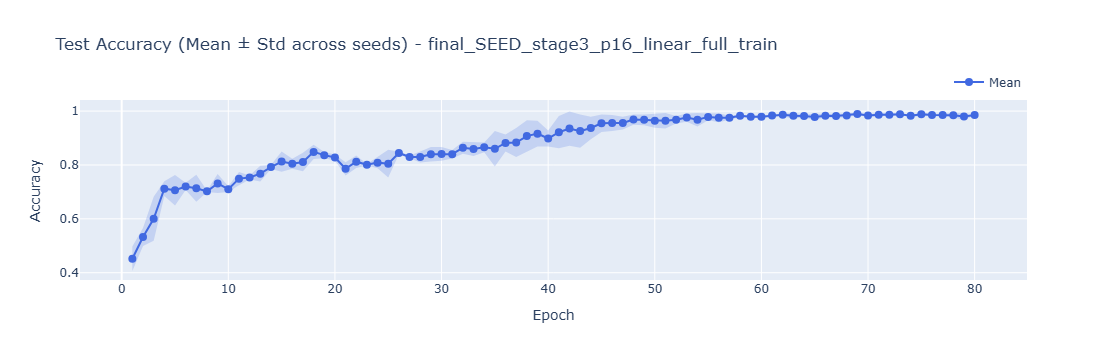

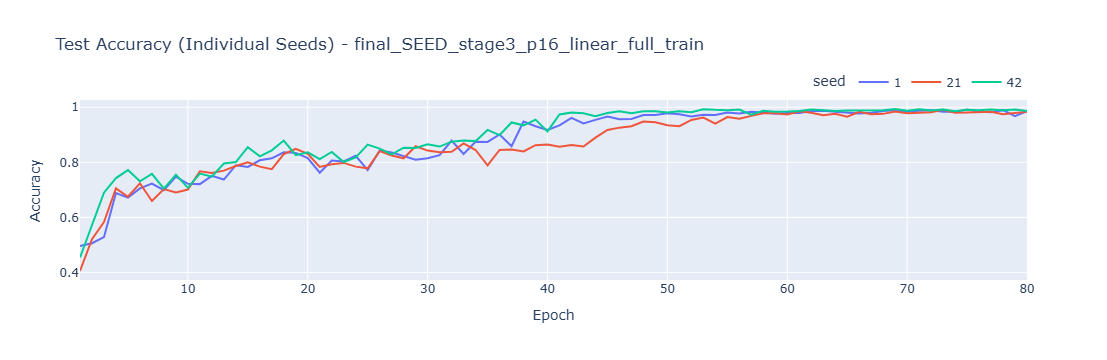


Evaluating configuration group: final_SEED_stage3_p16_linear_train

Evaluating seed 1 from 20250409_035637_4_final_s1_stage3_p16_linear_train
Loaded configuration from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_035637_4_final_s1_stage3_p16_linear_train/metadata/args.pickle
Using device: cuda:2
Num classes (k) =  9 ['class_1', 'class_2', 'class_3', 'class_4', 'class_5'] etc.
Detected 192 output channels from last conv layer
Number of prototypes set from 192 to 16. Extra 1x1 conv layer added.
Output shape: torch.Size([64, 16, 24, 24]), setting wshape=24
Using device_ids: [2]
Successfully loaded model state from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_035637_4_final_s1_stage3_p16_linear_train/checkpoints/net_trained_best
Checkpoint from epoch 79
Model accuracy: 0.9792
Evaluating model...



Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 17.03it/s]


Evaluation completed. Accuracy: 0.9711

Evaluating seed 21 from 20250409_054725_9_final_s21_stage3_p16_linear_train
Loaded configuration from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_054725_9_final_s21_stage3_p16_linear_train/metadata/args.pickle
Using device: cuda:2
Num classes (k) =  9 ['class_1', 'class_2', 'class_3', 'class_4', 'class_5'] etc.
Detected 192 output channels from last conv layer
Number of prototypes set from 192 to 16. Extra 1x1 conv layer added.
Output shape: torch.Size([64, 16, 24, 24]), setting wshape=24
Using device_ids: [2]
Successfully loaded model state from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_054725_9_final_s21_stage3_p16_linear_train/checkpoints/net_trained_best
Checkpoint from epoch 54
Model accuracy: 0.9885
Evaluating model...



Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 16.65it/s]

Evaluation completed. Accuracy: 0.9789

Evaluating seed 42 from 20250409_073802_14_final_s42_stage3_p16_linear_train
Loaded configuration from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_073802_14_final_s42_stage3_p16_linear_train/metadata/args.pickle
Using device: cuda:2
Num classes (k) =  9 ['class_1', 'class_2', 'class_3', 'class_4', 'class_5'] etc.


Detected 192 output channels from last conv layer
Number of prototypes set from 192 to 16. Extra 1x1 conv layer added.
Output shape: torch.Size([64, 16, 24, 24]), setting wshape=24
Using device_ids: [2]
Successfully loaded model state from /mnt/ssd-1/mechinterp/taras/Count_PIPNet/runs/final/20250409_073802_14_final_s42_stage3_p16_linear_train/checkpoints/net_trained_best
Checkpoint from epoch 78
Model accuracy: 0.9906
Evaluating model...



Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 16.19it/s]

Evaluation completed. Accuracy: 0.9789

Test accuracy across 3 seeds:
  Mean: 0.9763
  Std: 0.0037
  Range: 0.9711 - 0.9789


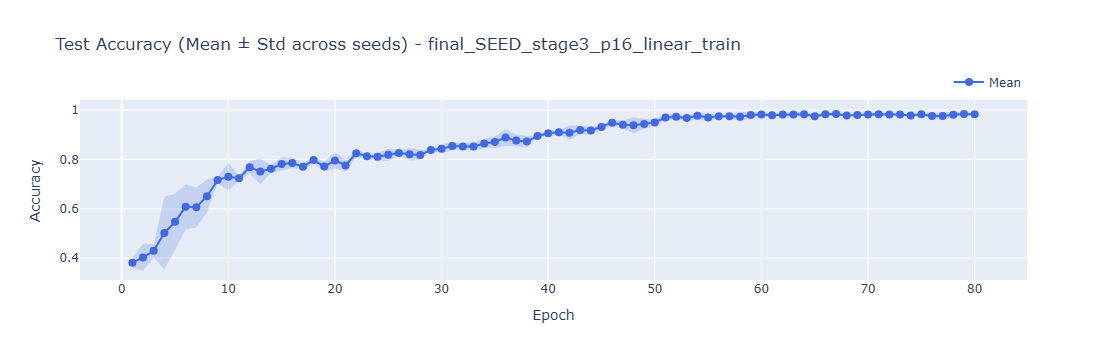

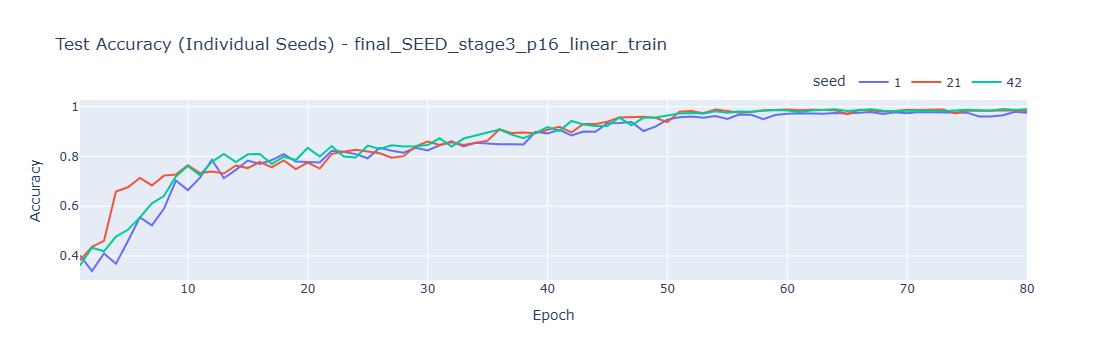


Summary of results by configuration:


,config,num_seeds,mean_accuracy,std_accuracy,min_accuracy,max_accuracy
3,final_SEED_stage3_p16_linear_full_train,3,0.985185,0.007554,0.977778,0.995556
4,final_SEED_stage3_p16_linear_train,3,0.976296,0.003666,0.971111,0.978889
2,final_SEED_stage3_p16_identity_train,3,0.848519,0.134165,0.667778,0.988889
1,final_SEED_stage3_p16_onehot_train,3,0.847037,0.025569,0.822222,0.882222
0,final_SEED_stage3_p16_linear,3,0.724815,0.032588,0.688889,0.767778



Configuration summary saved to /mnt/ssd-1/mechinterp/taras/Count_PIPNet/evaluations/config_results_summary.csv

Analysis complete!


In [44]:
# Evaluate each configuration group
all_group_results = []
for config_name, seed_runs in tqdm(config_groups.items(), desc="Evaluating configuration groups"):
    # Only evaluate groups with multiple seeds
    if len(seed_runs) >= 1:
        group_result = evaluate_run_group(config_name, seed_runs, eval_results_dir, 
                                          plot_confusion_matrix=False, metrics_to_plot=metrics_to_plot)
        all_group_results.append(group_result)

# Create a summary table of results
print("\nSummary of results by configuration:")
summary_data = []
for result in all_group_results:
    if 'mean_accuracy' in result:
        summary_data.append({
            'config': result['config_name'],
            'num_seeds': len(result['seeds']),
            'mean_accuracy': result['mean_accuracy'],
            'std_accuracy': result['std_accuracy'],
            'min_accuracy': min(result['test_accuracies']),
            'max_accuracy': max(result['test_accuracies'])
        })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('mean_accuracy', ascending=False)
    
    # Save to CSV
    summary_path = os.path.join(eval_results_dir, 'config_results_summary.csv')
    summary_df.to_csv(summary_path, index=False)
    
    # Print summary
    display(summary_df)
    print(f"\nConfiguration summary saved to {summary_path}")

print("\nAnalysis complete!")

## Plotting validation metrics

In [40]:
# List of metrics to plot
metrics_to_plot = [
    ('test_top1_acc', 'Test Accuracy', 'Accuracy'),
    # ('local_size_for_true_class', 'Local Size for True Classes', 'Size'),
    # ('local_size_all_classes', 'Local Size for All Classes', 'Size'),
    # ('almost_nonzeros_pooled', 'Non-zero prototypes count', 'Count')
]

In [26]:
# Visualize metrics for each configuration group
for config_name, seed_runs in config_groups.items():
    print(f"\nPlotting metrics for configuration: {config_name}")
    
    # Create output directory for this configuration
    config_output_dir = os.path.join(eval_results_dir, config_name)
    os.makedirs(config_output_dir, exist_ok=True)
    
    # Collect metrics DataFrames from all seeds in this configuration
    metrics_dfs = []
    for seed, run_dir, full_name in seed_runs:
        df = load_training_metrics(run_dir)
        if df is not None:
            # Add seed information to the DataFrame
            df['seed'] = seed
            df['full_name'] = full_name
            metrics_dfs.append(df)
    
    # Combine metrics from all seeds
    if metrics_dfs:
        combined_df = pd.concat(metrics_dfs, ignore_index=True)
        
        # Plot metrics with error bars
        plot_group_metrics(combined_df, config_output_dir, config_name, metrics_to_plot=metrics_to_plot)
    else:
        print(f"No metrics data available for configuration: {config_name}")